In [1]:
from skimage import io, measure
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re
from joblib import Parallel, delayed
import multiprocessing
import pandas as pd
from scipy.signal import savgol_filter
from scipy.stats import sem  # standard error of the mean


## Mean of growth change from multiple positions

In [22]:

# Function to process each position
def process_position(position):
    formatted_position = f"position_{position:02d}"
    # Input segmentation paths, adjust accordingly
    input_path =  f"E:/microscopy/20240201 - Glucose_Sucrose_SC/processed_layer9/FLO8-PP7_glucose_to_sucrose_SC/{formatted_position}/z_level_09/segmentation_0"

    image_files = sorted(glob.glob(os.path.join(input_path, 'frame_*.tif')))
    
    position_areas = {}
    first_frame_area = None
    
    for i, image_file in enumerate(image_files):
        img = io.imread(image_file, as_gray=True)
        thresholded_img = (img > 0).astype(np.uint8)
        labeled_img = measure.label(thresholded_img, connectivity=2)
        regions = measure.regionprops(labeled_img)
        total_area = sum(region.area for region in regions)
        
        # normalize by first frame
        
        if first_frame_area is None and total_area > 0:
            first_frame_area = total_area
        normalized_area =  total_area / first_frame_area if first_frame_area else 0 
        
        if i not in position_areas:
            position_areas[i]= []
        position_areas[i].append(normalized_area)
    
    return position_areas

In [23]:
positions = list(range(11))
all_frame_areas = {}

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(process_position)(position) for position in positions)

# Aggregate areas from all positions
for position_areas in results:
    for frame_index, areas in position_areas.items():
        if frame_index not in all_frame_areas:
            all_frame_areas[frame_index] = []
        all_frame_areas[frame_index].extend(areas)

# Calculate mean and standard deviation
mean_values = {frame: np.mean(areas) for frame, areas in all_frame_areas.items()}
std_dev_values = {frame: np.std(areas) for frame, areas in all_frame_areas.items()}

## Single scatter plot for all positions (mean normalized value)

In [ ]:
sorted_frames = sorted(all_frame_areas.keys())

# Extract mean and standard deviation in the order of sorted frames
means = [mean_values[frame] for frame in sorted_frames]
std_devs = [std_dev_values[frame] for frame in sorted_frames]

# params
time_interval_hours = 0.5  # half an hour interval of our imaging

# Frames to time
time_hours = [frame * time_interval_hours for frame in sorted_frames]
print(time_hours)

# Plot the mean value and std
plt.figure(figsize=(10, 5))


plt.plot(time_hours, means, 'o-', color='purple', label='Mean Area')
plt.errorbar(time_hours, means, yerr=std_devs, fmt='o', color='purple', ecolor='black', elinewidth=0.3, capsize=2, capthick=0.5, label='Std')
plt.text(2, plt.ylim()[1], 'Sucrose', color='red', ha='left', va='top')
plt.axvline(2, color='red', linestyle='dotted')


plt.title('Growth Glucose to Sucrose 24h (Synthetic dropout)')
plt.xlabel('Time (hours)')
plt.ylabel('Mean normalized Area')

#x-axis to show labels every one hour
plt.xticks(range(0, int(max(time_hours)) + 1, 1))

plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# # Create a DataFrame from the data
# df = pd.DataFrame({
#     'Time_hours': time_hours,
#     'Mean': means,
#     'StdDev': std_devs
# })

# # Save to a CSV file
# df.to_csv('E:/Scripts/Quantification/notebooks/carbon source switch/minimal.csv', index=False)


# Single positions

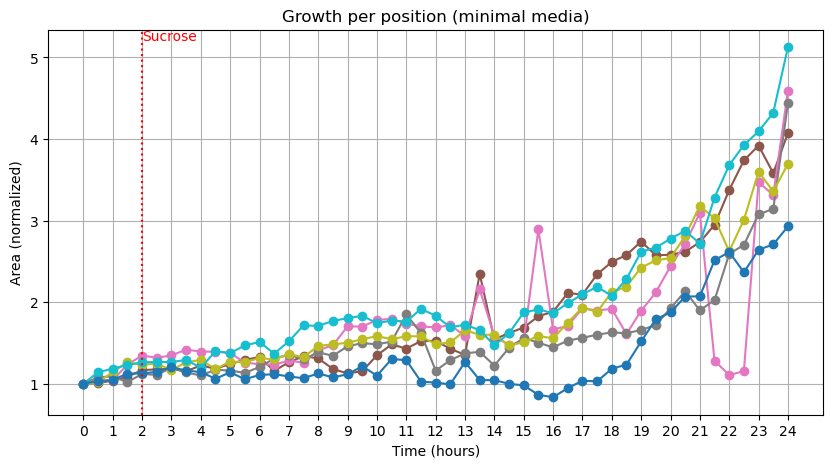

In [20]:
plt.figure(figsize=(10, 5))

# process positions
positions = list(range(11))
#multiproc
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(process_position)(position) for position in positions)

for position, position_areas in zip(positions, results):
    sorted_frames = sorted(position_areas.keys())
    time_hours = [frame * time_interval_hours for frame in sorted_frames]
    total_areas = [sum(position_areas[frame]) for frame in sorted_frames]

    # Plot for this position
    plt.plot(time_hours, total_areas, 'o-', label=f'Position {position}')

# Finalize plot details
plt.axvline(2, color='red', linestyle='dotted')
plt.text(2, plt.ylim()[1], 'Sucrose', color='red', ha='left', va='top')
plt.title('Growth per position (minimal media)')
plt.xlabel('Time (hours)')
plt.ylabel('Area (normalized)')
plt.xticks(range(0, int(max(time_hours)) + 1, 1))
plt.grid(True)
plt.show()


In [25]:
df1=  pd.read_csv('E:/Scripts/Quantification/notebooks/carbon source switch/minimal.csv')
df2= pd.read_csv('E:/Scripts/Quantification/notebooks/carbon source switch/Sc.csv')

In [26]:
time_hours1 = df1['Time_hours']
means1 = df1['Mean']
std_devs1 = df1['StdDev']

time_hours2 = df2['Time_hours']
means2 = df2['Mean']
std_devs2 = df2['StdDev']

## Comparison plot

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(time_hours1, means1, 'o-', color='red', label='Minimal media')
plt.errorbar(time_hours1, means1, yerr=std_devs1, fmt='o', color='red', ecolor='black', elinewidth=0.3, capsize=2, capthick=0.5)
plt.plot(time_hours2, means2, 'o-', color='purple', label='Synthetic drop out')
plt.errorbar(time_hours2, means2, yerr=std_devs2, fmt='o', color='purple', ecolor='black', elinewidth=0.3, capsize=2, capthick=0.5)

plt.text(2, plt.ylim()[1], 'Sucrose', color='red', ha='left', va='top')
plt.axvline(2, color='red', linestyle='dotted')


plt.title('Gowth Glucose to Sucrose 24h (Minimal vs Drop out)')
plt.xlabel('Time (hours)')
plt.ylabel('Mean normalized Area')

#x-axis to show labels every one hour
plt.xticks(range(0, int(max(time_hours)) + 1, 1))

plt.legend()
plt.grid(True)
plt.show()